In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
from numpy.polynomial.chebyshev import Chebyshev
#%matplotlib notebook
random_seed = 0
np.random.seed(seed=random_seed)
torch.manual_seed(random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, input_dim):
        super(HyperNetwork, self).__init__()
        self.input_dim = input_dim
        self.hyper_layer = FHatNetwork(1,[10],input_dim)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        params = torch.tanh(self.hyper_layer(alpha))
        params = params.view(self.input_dim, 1)
        return x@params

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        elif self.name == 'quantile':
            return self.quantile(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
   
    def quantile(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        return var
    
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def compute_cvar_h(self, alpha, h, env_dict):
        loss_fn = torch.nn.MSELoss()        
        risks = []
        for e in env_dict.keys():
            output = h(env_dict[e]['x'].to(self.device), alpha.to(self.device))
            risks.append(loss_fn(env_dict[e]['y'].to(self.device),output))
        risks = torch.stack(risks)
        cvar = self.aggregator.aggregate(risks, alpha)
        return cvar
    
    def iterative_implementation(self, h, cheb_approx, env_dict):
        loss_fn = torch.nn.MSELoss()  
        tests = np.random.uniform(low=0, high=1, size=20)
        tests = torch.tensor(tests, dtype=torch.float32).to(device)
        for test in tests:
            cvar_cheb = cheb_approx(test)
            with torch.no_grad():
                cvar_h = self.compute_cvar_h(test, h, env_dict)
            if cvar_cheb < cvar_h:
                return test
        return "exit"
    
    def fit_h(self, h, env_dict, 
              dist=None, optimizer=None, scheduler=None, alphas=None, num_epochs=10):
        
        if dist is not None:
            num_epochs = 100
            learning_rate = 0.1
            optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
            scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
            alphas = np.random.beta(a=0.1, b=0.2, size=20) if dist == "beta" else np.random.uniform(low=0, high=1, size=20)
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        for epoch in range(num_epochs):
            avg_cvar = torch.mean(torch.stack([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas]))
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 
    
    
    def fit_h_chebyshev(self, h, env_dict, start, budget):
        total = start+budget
        learning_rate = 0.03
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        alphas = np.cos((np.pi * (2 * np.arange(1, start + 1) - 1)) / (2 * start)) / 2 + 0.5
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device) 
        while (budget):
            self.fit_h(h, env_dict, dist = None, 
                       optimizer=optimizer, scheduler=scheduler, alphas=alphas)
            with torch.no_grad():
                cvar_values = np.array([self.compute_cvar_h(alpha, h, env_dict).cpu() for alpha in alphas])
                cheb_approx = Chebyshev.fit(alphas.cpu(), cvar_values, deg=total-1)
            alpha = self.iterative_implementation(h, cheb_approx, env_dict)
            if alpha == "exit":
                return 
            alphas = torch.cat((alphas,alpha.unsqueeze(0)), dim=0)
            budget=budget-1
        return 
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device),f(env_dict[e]['x'].to(self.device))) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            elif self.theta_dist == "beta":
                distribution = dist.Beta(0.1, 0.2)
            else:
                distribution1 = dist.Uniform(-1.1, -1)
                distribution2 = dist.Uniform(1, 1.1)
                decider = dist.Bernoulli(torch.tensor([0.5])).sample()
                distribution = distribution1 if decider==1 else distribution2
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            elif self.theta_dist == "beta":
                distribution = dist.Beta(0.1, 0.2)
            else:
                distribution1 = dist.Uniform(-1.1, -1)
                distribution2 = dist.Uniform(1, 1.1)
                decider = dist.Bernoulli(torch.tensor([0.5])).sample()
                distribution = distribution1 if decider==1 else distribution2
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

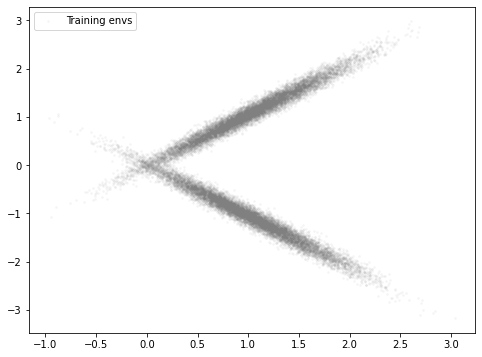

In [9]:
# Intitialize the experiment and generate the data
dim = 1
envs_train, envs_test = 250, 250
size_train, size_test = 100 , 100
theta_dist="mixed" 
rho="cvar"

generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')
fig.savefig("env.pdf", format='pdf', bbox_inches='tight')

In [10]:
import copy
def fixed(data_dict_train, dim, alphas):
    h = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h_chebyshev(h, data_dict_train, 10, 10)
    h_cheb = copy.deepcopy(h)
    print("Cheb Trained")  
    h = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h, data_dict_train, "uniform")
    h_unif = copy.deepcopy(h)
    print("Uniform Trained")
    h = HyperNetwork(dim).to(device)
    ARM_Regression(name=rho).fit_h(h, data_dict_train, "beta")
    h_beta = copy.deepcopy(h)
    print("Beta Trained")
    
    f = FHatNetwork(dim,[],1).to(device)
    groundtruths = []
    for alpha in alphas:
        ARM_Regression(name=rho).fit_f(f, data_dict_train, alpha)
        groundtruths.append(copy.deepcopy(f))
        
    return groundtruths, h_unif, h_beta, h_cheb

In [11]:
def execute(true_alpha, ground_truth_f, h_unif, h_beta, h_cheb, data_dict_test):
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, ground_truth_f(x)).cpu()) 
        train_risks = torch.stack(train_risks)
    groundtruth_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)

    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, h_unif(x,torch.tensor(true_alpha).to(device))).cpu()) 
        train_risks = torch.stack(train_risks)
    unif_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, h_beta(x,torch.tensor(true_alpha).to(device))).cpu()) 
        train_risks = torch.stack(train_risks)
    beta_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, h_cheb(x,torch.tensor(true_alpha).to(device))).cpu()) 
        train_risks = torch.stack(train_risks)
    cheb_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    return groundtruth_cvar.item(), unif_cvar.item(), beta_cvar.item(), cheb_cvar.item()

In [12]:
# New function to reset seeds and reinitialize models
def reinitialize_models(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return fixed(data_dict_train, dim, true_alphas)

# Main loop for iterating over different seeds
num_seeds = [0,1,2,3,4,5]  # Number of different seeds to use
true_alphas = [0.0, 0.1, 0.2, 0.4, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
results = {str(true_alpha): {"GT": [], "Unif": [], "Beta": [], "Cheb": []} for true_alpha in true_alphas}

for seed in num_seeds:
    # Reinitialize models with the new seed
    ground_truths, h_unif, h_beta, h_cheb = reinitialize_models(seed)
    
    for index in range(len(true_alphas)):
        ground_truth, uniform, beta, cheb = execute(true_alphas[index], ground_truths[index], h_unif, h_beta, h_cheb, data_dict_test)    
        # Collecting the results
        results[str(true_alphas[index])]["GT"].append(ground_truth)
        results[str(true_alphas[index])]["Unif"].append(uniform)
        results[str(true_alphas[index])]["Beta"].append(beta)
        results[str(true_alphas[index])]["Cheb"].append(cheb)

Epoch [10/10], Loss: 1.6506470441818237
Epoch [10/10], Loss: 1.5395830869674683
Epoch [10/10], Loss: 1.5548522472381592
Epoch [10/10], Loss: 1.5523855686187744
Epoch [10/10], Loss: 1.5425904989242554
Epoch [10/10], Loss: 1.5359481573104858
Epoch [10/10], Loss: 1.5369020700454712
Epoch [10/10], Loss: 1.5349280834197998
Epoch [10/10], Loss: 1.5412088632583618
Epoch [10/10], Loss: 1.5421030521392822
Cheb Trained
Epoch [10/100], Loss: 1.67375910282135
Epoch [20/100], Loss: 1.5221055746078491
Epoch [30/100], Loss: 1.519657015800476
Epoch [40/100], Loss: 1.519386649131775
Epoch [50/100], Loss: 1.5160924196243286
Epoch [60/100], Loss: 1.5144609212875366
Epoch [70/100], Loss: 1.5145567655563354
Epoch [80/100], Loss: 1.5144925117492676
Epoch [90/100], Loss: 1.5144776105880737
Epoch [100/100], Loss: 1.5144591331481934
Uniform Trained
Epoch [10/100], Loss: 1.5606021881103516
Epoch [20/100], Loss: 1.603652834892273
Epoch [30/100], Loss: 1.5526584386825562
Epoch [40/100], Loss: 1.5509895086288452
E

Epoch [100/100], Loss: 1.444366455078125
Epoch [100/100], Loss: 1.484233021736145
Epoch [100/100], Loss: 1.464176058769226
Epoch [100/100], Loss: 1.5066193342208862
Epoch [100/100], Loss: 1.5312501192092896
Epoch [100/100], Loss: 1.5602816343307495
Epoch [100/100], Loss: 1.5961239337921143
Epoch [100/100], Loss: 1.653200387954712
Epoch [100/100], Loss: 1.7710151672363281
Epoch [10/10], Loss: 1.648074746131897
Epoch [10/10], Loss: 1.5450725555419922
Epoch [10/10], Loss: 1.5475714206695557
Epoch [10/10], Loss: 1.5403696298599243
Epoch [10/10], Loss: 1.5369113683700562
Epoch [10/10], Loss: 1.546331763267517
Epoch [10/10], Loss: 1.5595942735671997
Epoch [10/10], Loss: 1.5608619451522827
Epoch [10/10], Loss: 1.5590606927871704
Epoch [10/10], Loss: 1.555348515510559
Cheb Trained
Epoch [10/100], Loss: 1.7805054187774658
Epoch [20/100], Loss: 1.5941613912582397
Epoch [30/100], Loss: 1.5582356452941895
Epoch [40/100], Loss: 1.5164037942886353
Epoch [50/100], Loss: 1.521053671836853
Epoch [60/10

In [13]:
def compute_statistics(results):
    means = {}
    std_devs = {}

    for key, value in results.items():
        # Ensure value is a list of numbers, not a dictionary
        if isinstance(value, dict):
            means[key] = {sub_key: np.mean(sub_value) for sub_key, sub_value in value.items()}
            std_devs[key] = {sub_key: np.std(sub_value) for sub_key, sub_value in value.items()}
        else:
            means[key] = np.mean(value)
            std_devs[key] = np.std(value)

    return means, std_devs
means, std_devs = compute_statistics(results)

In [14]:
for key in results.keys():
    print(round(means[key]['GT'],4),std_devs[key]['GT'])

1.3893 0.00022084137483529718
1.4128 4.8751680701972404e-05
1.435 6.861660254658468e-05
1.4764 6.598625427082305e-05
1.4557 0.00026792287826538086
1.4984 0.00020760297775268555
1.524 0.0004589557647705078
1.5519 1.0132789611816406e-06
1.5879 0.0015958547592163086
1.6334 0.00026667118072509766
1.7139 0.004479646682739258


In [15]:
for key in results.keys():
    print(round(means[key]['Unif'],4),std_devs[key]['Unif'])

1.3888 0.0002775483526460708
1.4131 0.00011049986869878417
1.4353 0.0001585953957085452
1.4763 7.471743568282198e-05
1.4555 9.213766800314132e-05
1.4983 9.64623032601163e-05
1.5224 0.00026714672938670734
1.5521 1.6805080683274097e-05
1.5863 0.00010367987098748898
1.6345 0.0010532389298949626
1.7118 0.0031490566746310796


In [16]:
for key in results.keys():
    print(round(means[key]['Cheb'],4),std_devs[key]['Cheb'])

1.3888 0.00028340460596508764
1.4132 0.00042488734871408445
1.4352 0.00015828202680149656
1.4764 0.00016171501248539856
1.4555 0.00014784190113577514
1.4986 0.00037558379938867746
1.5228 0.0004301588528128876
1.5521 1.5770507452911017e-05
1.5862 1.937687832047502e-05
1.6338 0.0007151990027465946
1.7101 0.0011107006904452503


In [17]:
for key in results.keys():
    print(round(means[key]['Beta'],4),std_devs[key]['Beta'])

1.3893 0.0003130299879438686
1.4131 0.00031757569340664754
1.4353 0.00027063947081995614
1.4767 0.0007501858390084528
1.4559 0.0007016285085054866
1.4986 0.0005607568209649261
1.5229 0.0011044693542039527
1.5529 0.0012197345114045375
1.5874 0.00198122722547041
1.6336 0.0011390223551991738
1.7114 0.00282215120107741
